# Visualizing S(T,P) for water as a gas, liquid or solid
Computational Guided Inquiry for Physical Chemistry Written by Dr. Steven Neshyba (University of Puget Sound)

Adapted for Chem 152 at Santa Clara University by Dr. Grace Stokes

## Introduction
Today, our goal is to construct 3-D plots of $S(T,P)$ for water in its gas, liquid, and solid forms. We'll do that by integrating the differential equation of state for the entropy, 

$$
dS = \frac {C_P} T dT -V \beta dP \ \ \ \ (1)
$$

Since Eq. (1) could also be written $dS = \big (\partial S/ \partial T \big )_P dT + \big (\partial S/ \partial P \big )_T dP$, we'll use the following interchangeably:

$$
\big (\partial S/ \partial T \big )_P = \frac {C_{P}}T \ \ \ \ (2)
$$

$$
\big (\partial S/ \partial P \big )_T = -V \beta \ \ \ \ (3)
$$

Equation (1) would apply to any pure substance, e.g., for liquid water we'd use $\frac {C_{P,liq}}T$ for the first term, and $V_{liq}$ and $\beta_{liq}$, and so on. For precise work, we'd want to specify these quantities as temperature- and pressure-dependent quantities. However, for our present purposes, a few assumptions will simplify matters a lot, and still produce reasonable results:

1. We'll assume $C_P=constant$ for each phase. 
2. For water *vapor*, if we assume ideal gas behavior, it turns out that 

$$
V \beta \approx nR/P \ \ \ \ (4)
$$

3. For *liquid* and *solid* water, we'll say 

$$
V \beta \approx constant \ \ \ \ (5)
$$

All these quantities, as written, are on a per-mole basis, according to the constants we've set up above.

And how do we carry out the integration of Eq. (1)? We *could* do it analytically, but it's a lot easier to do so numerically, once we have numerical versions of $\big (\partial S/ \partial T \big )_P$ and $\big (\partial S/ \partial P \big )_T$. The Python function is called PL.Integrator and Dr. Stokes has not figured out how to use it with Google Colab so we are doing today's experiment in the ChemCompute platform!

One last note: integrating Eq. (1) will tell us the shape of each surface ($S_{gas}(T,P)$, $S_{liq}(T,P)$, and $S_{sol}(T,P)$), but it won't tell us how they're related to one another. To accomplish that, PL.Integrator also has built in the ability to offset each surface by the standard-state entropy appropriate to the each phase (see values at https://webbook.nist.gov/chemistry/name-ser/). 


## Learning Goals
1. Explain what controls the shape of $\big (\partial S/ \partial T \big )_P$, $\big (\partial S/ \partial P \big )_T$, and $S$ in $T,P$ state space, and how these shapes differ according to phase. 
1. Use a 2-d integrator to construct a numerical representation of a state function.
1. Explain trends in $\Delta S_{vap}$, $\Delta S_{fus}$, and $\Delta S_{sub}$ with increasing temperature and pressure.

## Part 1. Import Libraries

In [1]:
pip install pint

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import resources - execute this cell two times (hit SHIFT-ENTER) because we want interactive graphics
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
import matplotlib.pyplot as plt
import PchemLibrary as PL
from mpl_toolkits.mplot3d import axes3d
import sympy as sp
%matplotlib notebook

## Part 2.  Define thermochemical constants pertaining to water

There are two places you need to fill in values:
1) You ned to enter values for the volumetric thermal expansion coefficient for liquid water (beta_liq) and solid water (beta_sol), which are found in Table 3.1 in Engel and Reid. They are currently listed as 0.00e-4. Don't change the exponential, just the decimal value.

2) You will also need to enter the standard state entropy values of gaseous water (SS_gas) and liquid water (SS_liq) which are found at https://webbook.nist.gov/chemistry/name-ser/.  Note that liquids are considered a "condensed phase." I provide SS_sol below. No need to change the units or anything else about the code.

In [5]:
# Lay out the temperature-pressure state space
Tgrid, Pgrid_bar = PL.Statespace([200,400,100],[1,10,101])
Pgrid = AssignQuantity(Pgrid_bar,'bar').to('pascal')
Tgrid = AssignQuantity(Tgrid,'K')

# The code below defines some constants
# Gas constant in SI units
R = AssignQuantity(8.314,'J /mol/K')
# Standard state conditions, in SI units
T0 = AssignQuantity(298,'K')
P0 = AssignQuantity(1e5,'pascal')

# Some SI units related to entropy
EUnits = 'J/K/mol'
dSdTUnits = 'J / kelvin^2 /mole'
dSdPUnits = 'meter ** 3 / kelvin / mole'

# Molar mass of water is 18 g/mol but we must convert it to SI units (kg/mol)
M = AssignQuantity(18,'g/mol')
M.ito('kg/mol')
print(M)

# Parameters for gaseous water
CP_gas = AssignQuantity(33.6,EUnits)
SS_gas = [T0,P0,AssignQuantity(188.835,EUnits)] # Specifying the standard state entropy

# Parameters for liquid water
Vgrid_liq = AssignQuantity(0.018,'m^3 /mol')*np.ones(np.shape(Pgrid)) # Molar volume, as a state-space grid
beta_liq = AssignQuantity(2.04e-4,'1/K') # Thermal expansivity of liquid water
CP_liq = AssignQuantity(75.4,EUnits) # Heat capacity
SS_liq = [T0,P0,AssignQuantity(69.95,EUnits)]
print('CP_liq =', CP_liq)

# Parameters for ice water
Vgrid_sol = 1.1*Vgrid_liq # 10% of icebergs are above the water
beta_sol =  AssignQuantity(1.66e-4,'1/K') # Thermal expansivity of ice
CP_sol = AssignQuantity(38,EUnits)
SS_sol = [T0,P0,AssignQuantity(46.5,EUnits)]
print('CP_sol =', CP_sol)

0.018000000000000002 kilogram / mole
CP_liq = 75.4 joule / kelvin / mole
CP_sol = 38 joule / kelvin / mole


## Pause for analysis #1
Compare the thermal expansivity of liquid water compared to the thermal expansivity of ice (solid). Which one is larger? Does it make sense based on the definition of molar expansivity?

Answer:

## Part 3. Let's have a look at the $\big (\partial S/ \partial T \big )_P$ for the gas
Below, we calculate and display $\big (\partial S/ \partial T \big )_P = \frac {C_{P,gas}}T$, using gray to represent a foggy morning. All you need to do is hit "SHIFT-ENTER" see if the shape of the graph matches what we expected.

<IPython.core.display.Javascript object>


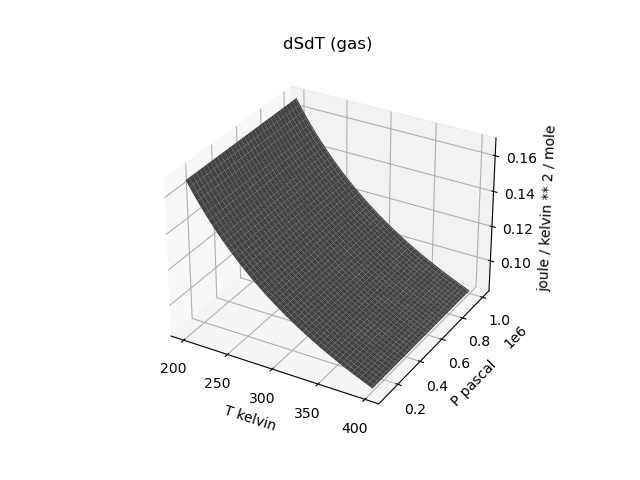

Text(0.5, 0.92, 'dSdT (gas)')

In [6]:
# dSdT for the gas
dSdT_gas = CP_gas/Tgrid

# The rest is graphics
xlabel = "T "+str(Tgrid.units)
ylabel = "P "+str(Pgrid.units)
ax = PL.plot_surface(Tgrid, Pgrid, dSdT_gas, color='gray')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(str(dSdT_gas.units))
ax.set_title('dSdT (gas)')

## Part 4. Now you must plot $\big (\partial S/ \partial T \big )_P$ for the liquid
In the first line of the cell below, calculate $\big (\partial S/ \partial T \big )_P = \frac {C_{P,liq}} T$. Then plot $\big (\partial S/ \partial T \big )_P$ for liquid *and* gas on the same graph. To help keep things straight, make the liquid blue-colored (like the ocean), and keep the gas gray-colored.

In [ ]:
# define dSdT for the liquid



# Graphics
# This allows us to make vertical scales the same
zmax1 = np.max(np.max(dSdT_liq)); print(zmax1)
zmax2 = np.max(np.max(dSdT_gas)); print(zmax2)
zmax = np.max([zmax1.magnitude,zmax2.magnitude])

xlabel = "T "+str(Tgrid.units)
ylabel = "P "+str(Pgrid.units)


# Make a legend in the title
ax.set_title('dSdT (liq=blue, gas=gray)')

#Overlay the two plots using the code below
ax = PL.plot_surface(Tgrid, Pgrid, dSdT_liq, color='blue')
ax = PL.plot_surface(Tgrid, Pgrid, dSdT_gas, color='gray', overlay=True, ax=ax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(str(dSdT_liq.units))
ax.set_zlim([0,zmax])


## Pause for analysis #2
The slope of the blue plot is much steeper than the slope of the grey plot. Explain the reason for this difference. Which is more temperature-dependent at constant pressure -- the entropy for liquids or gases? Why? 

Answer:

## Part 5. Overlay $\big (\partial S/ \partial T \big )_P$ surface for the solid
In the cell below, calculate $\big (\partial S/ \partial T \big )_P = \frac {C_{P,sol}} T$. Then plot $\big (\partial S/ \partial T \big )_P$ for solid, liquid and gas on the same graph. To help keep things straight, make the solid black-colored, and keep the gas and liquid as before.

In [ ]:
# dSdT for the solid


# This allows us to make vertical scales the same
zmax1 = np.max(np.max(dSdT_sol)); print(zmax1)
zmax2 = np.max(np.max(dSdT_liq)); print(zmax2)
zmax3 = np.max(np.max(dSdT_gas)); print(zmax3)
zmax = np.max([zmax1.magnitude,zmax2.magnitude,zmax3.magnitude])

# Graphics
xlabel = "T "+str(Tgrid.units)
ylabel = "P "+str(Pgrid.units)
ax = PL.plot_surface(Tgrid, Pgrid, dSdT_sol, color='black')
ax.set_zlim([0,zmax])
ax = PL.plot_surface(Tgrid, Pgrid, dSdT_liq, color='blue', overlay=True, ax=ax)
ax = PL.plot_surface(Tgrid, Pgrid, dSdT_gas, color='gray', overlay=True, ax=ax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(str(dSdT_liq.units))

# Make a legend in the title
ax.set_title('dSdT (sol=black, liq=blue, gas=gray)')


## Pause for analysis #3

Based on differences in their heat capacities, compare the slopes of the solid, liquids and gases.

Answer:

## Part 7. Now plot $\big (\partial S/ \partial P \big )_T$ and compare it to $\big (\partial S/ \partial T \big )_P$

In the cell below, calculate and plot $\big (\partial S/ \partial P \big )_T$ for all three phases of water (see the Introduction for equations). Some cosmetic considerations you might want to think about:

- It'll be best if you use the same coloring convention as before. 
- You might find it convenient to multiply your $\big (\partial S/ \partial P \big )_T$ values by some big number "on the fly", as in

    ax.plot_surface(Tgrid, Pgrid, dSdP_gas*1e5, color='gray')
    
    

In [ ]:
# dSdP


# Graphics



# Display a title with legend


## Pause for analysis #4
You've probably noticed that $\big (\partial S/ \partial P \big )_T$ for the liquid and solid are almost identical constant compared to the variability of $\big (\partial S/ \partial P \big )_T$ of the gas. What do you suppose accounts for the difference?

ANSWER:

# Grading:  

As before, I will be looking for evidence of your mastery of the computational methods embedded in this exercise in google colaboratory: whether the notebook is complete and your results accurate, in addition to the answers to the Pause for Analysis questions.